In [185]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [186]:
# datasets

def get_random_sequence(length=10, n_classes=10):
    sequence = torch.randint(low=0, high=n_classes, size=(length,)).squeeze(0).long()
    # compute max for each subsequence - better training
    max_for_subsequence = torch.tensor([torch.max(sequence[:i+1]).item() for i in range(len(sequence))])
    return (sequence, max_for_subsequence)


In [187]:
get_random_sequence(length=16, n_classes=50)

(tensor([29, 49,  3, 31, 20,  3, 18, 38, 20, 14,  3, 15, 26, 44, 17, 17]),
 tensor([29, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49, 49]))

In [188]:
# model definitions

class AdaptiveSoftmax(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        # self.poly_fit = nn.Parameter(torch.randn(5), requires_grad=True)
        self.poly_fit = [-0.037, 0.481, -2.3, 4.917, -1.791]  # from "Softmax is not Enough" Figure 6

    def _get_polynomial_value(self, x: float, c: torch.Tensor) -> float:
        cur_val = 0
        for i in range(len(c) - 1):
            cur_val = (cur_val + c[i]) * x
        return cur_val + c[-1]

    def forward(self, logits):
        """
        from "Softmax is not Enough" Figure 4, adapted to PyTorch
        """
        original_probs = torch.softmax(logits, dim=self.dim)
        # print(torch.min(original_probs), torch.max(original_probs))
        entropy = torch.sum(-original_probs * torch.log(original_probs + 1e-9), axis=-1, keepdims=True) # compute the Shannon entropy
        beta = torch.where(
            entropy > 0.5,  # don’t overcorrect low-entropy heads
            torch.maximum(self._get_polynomial_value(entropy, self.poly_fit), torch.tensor(1.0)),  # never increase entropy
            torch.tensor(1.0)
        )
        return torch.softmax(logits * beta, dim=self.dim)
    
    
class MyAttention(nn.Module):
    def __init__(self, d_model, d_internal, adaptive_softmax: bool = True):
        """
        :param d_model: The dimension of the inputs and outputs of the layer (note that the inputs and outputs
        have to be the same size for the residual connection to work)
        :param d_internal: The "internal" dimension used in the self-attention computation. Your keys and queries
        should both be of this length.
        """
        super().__init__()
        self.d_model = d_model
        self.d_internal = d_internal
        self.sqrt_d = torch.sqrt(torch.tensor(d_internal, dtype=torch.float32))

        self.w_q = nn.Linear(d_model, d_internal, bias=False)
        self.w_k = nn.Linear(d_model, d_internal, bias=False)
        self.w_v = nn.Linear(d_model, d_model, bias=False)

        self.softmax = AdaptiveSoftmax(dim=-1)
        self.adaptive_softmax = adaptive_softmax

    def forward(self, input_vecs: torch.Tensor):
        q, k, v = self.w_q(input_vecs), self.w_k(input_vecs), self.w_v(input_vecs)
    
        s = q @ k.transpose(-2, -1)

        a = (s / self.sqrt_d)
        
        # mask future tokens
        seq_len = input_vecs.shape[1]
        mask = torch.tril(torch.ones((seq_len, seq_len)))
        a = a.masked_fill(mask == 0, 1e-9)
        
        # print(f"before softmax: min={a.min().item()}, max={a.max().item()}")
        a = self.softmax(a) if self.adaptive_softmax else torch.softmax(a, dim=-1)
        # print(f"after softmax: min={a.min().item()}, max={a.max().item()}")
          
        z = a @ v

        attention_is_all_you_need = z + input_vecs
        

        return attention_is_all_you_need, a

class MaxNN(torch.nn.Module):
    def __init__(self, n_classes=10, n_feats=128, activation=torch.nn.GELU(), adaptive_softmax: bool = False):
        super().__init__()
        self.n_classes = n_classes
        self.n_feats = n_feats
        self.activation = activation
        
        self.embedding = nn.Embedding(n_classes, n_feats)

        self.attention = MyAttention(d_model=n_feats, d_internal=n_feats, adaptive_softmax=adaptive_softmax)

        self.final_dense1 = nn.Linear(n_feats, n_feats)
        self.final_dense2 = nn.Linear(n_feats, n_classes)
        
        self.attention_patterns = []
        
    
    def forward(self, x, capture_attention=False):

        # Process x through dense layers
        x = self.embedding(x)
            
        # print(f"{x.shape=}")
        attn_output, attention_pattern = self.attention(x)
        # print(f"{attn_output.shape=} {attention_pattern.shape=}")
        if capture_attention:
            self.attention_patterns.append(attention_pattern.detach().cpu())
        
        x = attn_output
        
        # Final dense layers
        x = self.final_dense1(x)
        x = self.activation(x)
        x = self.final_dense2(x)

        return x
    
    def get_attention_pattern(self):
        patterns = self.attention_patterns
        self.attention_patterns = []
        return patterns
      

  
  
# POLY_FIT = torch.tensor([-0.037, 0.481, -2.3, 4.917, -1.791]) # Figure 6

# def softmax_adaptive_temperature(logits, dim, poly_fit=POLY_FIT, dtype=torch.float32):
#     """
#     from "Softmax is not Enough" Figure 4, adapted to PyTorch
#     """
#     original_probs = torch.softmax(logits, dim=dim, dtype=dtype)
#     entropy = torch.sum(-original_probs * torch.log(original_probs + 1e-9), axis=-1, keepdims=True) # compute the Shannon entropy
#     beta = torch.where(
#         entropy > 0.5,  # don’t overcorrect low-entropy heads
#         torch.maximum(get_polynomial_value(entropy, poly_fit), torch.tensor(1.0)),  # never increase entropy
#         torch.tensor(1.0)
#     )
#     return torch.softmax(logits * beta, dim=dim, dtype=dtype)

In [189]:
TRAINING_LENGTH = 16
CLASSES = 30


train_dataloader = torch.utils.data.DataLoader(
    [get_random_sequence(TRAINING_LENGTH, CLASSES) for _ in range(10_000)], batch_size=20, shuffle=True
)

model_softmax = MaxNN(n_classes=CLASSES, n_feats=128)
model_adaptive_softmax = MaxNN(n_classes=CLASSES, n_feats=128, adaptive_softmax=True)


In [190]:
# train both models

for model in [model_softmax, model_adaptive_softmax][::-1]:
  model.train()
  loss = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-5)

  for epoch in range(10): # 100_000 steps total
    sum_loss = 0.0
    for i, (x, y) in enumerate(train_dataloader):
        logits = model(x)
        # each logit is [batch, token, class_one_hot]
        l = loss(logits.reshape(-1, logits.shape[-1]), y.reshape(-1))
        l.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.5) # clip the gradients
        optimizer.step()
        optimizer.zero_grad()
        sum_loss += l.item()
        
    print(f"Epoch {epoch}: Train loss = {sum_loss / len(train_dataloader)}")

Epoch 0: Train loss = 3.270061618804932
Epoch 1: Train loss = 2.6899630463123323
Epoch 1: Train loss = 2.6899630463123323
Epoch 2: Train loss = 2.0935178995132446
Epoch 2: Train loss = 2.0935178995132446
Epoch 3: Train loss = 1.6050369671583176
Epoch 3: Train loss = 1.6050369671583176
Epoch 4: Train loss = 1.2068244695663453
Epoch 4: Train loss = 1.2068244695663453
Epoch 5: Train loss = 0.9769667340517044
Epoch 5: Train loss = 0.9769667340517044
Epoch 6: Train loss = 0.8226509194374084
Epoch 6: Train loss = 0.8226509194374084
Epoch 7: Train loss = 0.7175153442621232
Epoch 7: Train loss = 0.7175153442621232
Epoch 8: Train loss = 0.640042587697506
Epoch 8: Train loss = 0.640042587697506
Epoch 9: Train loss = 0.594151939690113
Epoch 9: Train loss = 0.594151939690113
Epoch 0: Train loss = 3.2837293701171877
Epoch 0: Train loss = 3.2837293701171877
Epoch 1: Train loss = 2.9672327213287355
Epoch 1: Train loss = 2.9672327213287355
Epoch 2: Train loss = 2.385585722208023
Epoch 2: Train loss = 

In [191]:
# evaluate both models on different sequence lengths

TESTING_LENGTHS = [16, 32, 64, 128, 256, 512, 1024, 2048]
interesting_logit_indices = torch.tensor([length - 1 for length in TESTING_LENGTHS])


from collections import defaultdict
results = defaultdict(dict)
for i, model in enumerate([model_softmax, model_adaptive_softmax]):
  loss = nn.CrossEntropyLoss()
  model.eval()
  
  for length in TESTING_LENGTHS:
    sum_loss = 0.0
    for test_case in range(32):
        sequence, target = get_random_sequence(length=length, n_classes=CLASSES)
        
        logits = model(sequence.unsqueeze(0), capture_attention=True)
        
        l = loss(logits[:, -1, :], target[-1].unsqueeze(0))
        sum_loss += l.item()
        
    avg_loss = sum_loss / 32.0
    

    attention_patterns = model.get_attention_pattern()
    # get attention patterns for last query position for the last 16 keys
    last_logit_attentions = [a[0, -16:, -1] for a in attention_patterns]
    print(f"{last_logit_attentions[0].shape=}")

    # model 0=softmax, model 1=adaptive_softmax
    results[length][i] = {
        "loss": avg_loss,
        "attention": last_logit_attentions
    }
    
    print(f"Length={length}: Test loss = {avg_loss}")


last_logit_attentions[0].shape=torch.Size([16])
Length=16: Test loss = 0.016748466576245846
last_logit_attentions[0].shape=torch.Size([16])
Length=32: Test loss = 0.012479860819439637
last_logit_attentions[0].shape=torch.Size([16])
Length=64: Test loss = 0.026547231536824256
last_logit_attentions[0].shape=torch.Size([16])
Length=128: Test loss = 0.007316343171623885
last_logit_attentions[0].shape=torch.Size([16])
Length=256: Test loss = 0.0063367759830725845
last_logit_attentions[0].shape=torch.Size([16])
Length=256: Test loss = 0.0063367759830725845
last_logit_attentions[0].shape=torch.Size([16])
Length=512: Test loss = 0.005038321176471072
last_logit_attentions[0].shape=torch.Size([16])
Length=512: Test loss = 0.005038321176471072
last_logit_attentions[0].shape=torch.Size([16])
Length=1024: Test loss = 0.0052961137298552785
last_logit_attentions[0].shape=torch.Size([16])
Length=1024: Test loss = 0.0052961137298552785
last_logit_attentions[0].shape=torch.Size([16])
Length=2048: Test l

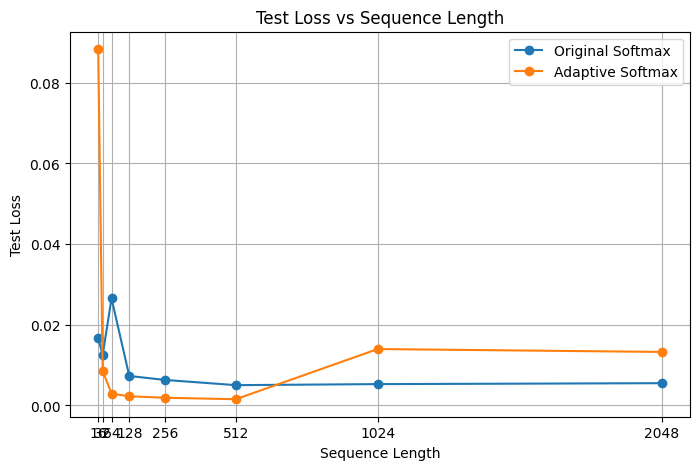

In [192]:
# plot test losses

lengths = sorted(results.keys())
original_losses = [results[length][0]['loss'] for length in lengths]
adaptive_losses = [results[length][1]['loss'] for length in lengths]

plt.figure(figsize=(8, 5))
plt.plot(lengths, original_losses, marker='o', label='Original Softmax')
plt.plot(lengths, adaptive_losses, marker='o', label='Adaptive Softmax')
plt.xlabel('Sequence Length')
plt.ylabel('Test Loss')
plt.title('Test Loss vs Sequence Length')
plt.xticks(lengths)
plt.legend()
plt.grid(True)
plt.show()

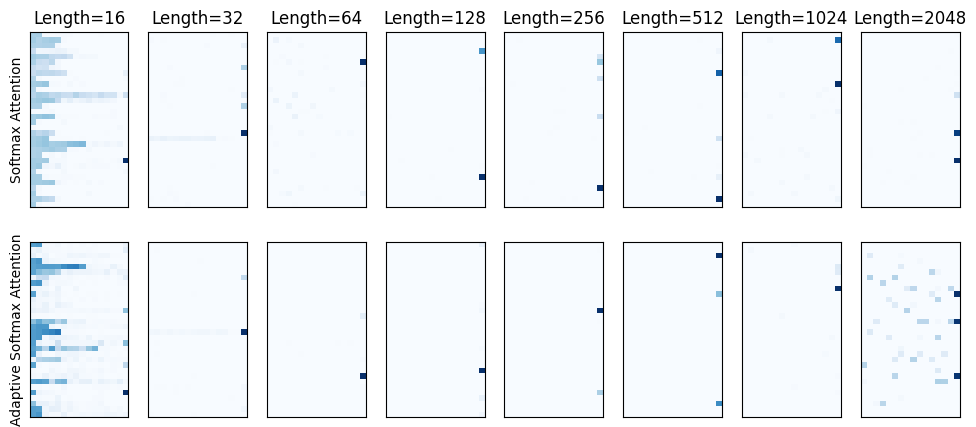

In [193]:
# plot activations

fig, ax = plt.subplots(2, len(TESTING_LENGTHS), figsize=(12, 5))
ax[0, 0].set_ylabel('Softmax Attention')
ax[1, 0].set_ylabel('Adaptive Softmax Attention')
for length in TESTING_LENGTHS:
    for i in [0, 1]:  # 0=softmax, 1=adaptive_softmax
        attention_patterns = results[length][i]['attention']
        attentions_2d = torch.stack(attention_patterns, dim=0)  # shape: (num_cases, key_positions)
        
        ax[i, TESTING_LENGTHS.index(length)].imshow(attentions_2d, cmap='Blues', aspect='auto')
        ax[i, TESTING_LENGTHS.index(length)].set_xticks([])
        ax[i, TESTING_LENGTHS.index(length)].set_yticks([])
        
    ax[0, TESTING_LENGTHS.index(length)].set_title(f'Length={length}')